# Linear Gaussian State Space Model

As a first approach to the problem of choosing a proposal for Sequential Monte Carlo (SMC), let's consider a simple linear gaussian state space model. This way, it will be possible to compare obtained results to those provided by a Kalman filter.

We will consider the following model: 
$$
\begin{array}{l}
X_{t+1} = A X_t + W_t\\
Y_{t+1} = B X_t + V_t
\end{array}
$$
where $\ X_0 \sim \mathcal{N}(0, I), \ W_t \sim \mathcal{N}(0,Q) \ \textrm{and} \ V_t \sim \mathcal{N}(0, R)$. Our interest is to estimate the latent variables $X_{1:T}$.

In this scenario, we have the following distributions:
- Prior: $\begin{cases}f (x_0) = \mathcal{N} (x_0; 0, I);\\ f(x_t | x_{t-1}) = \mathcal{N}(x_t; A x_{t-1},Q Q^T);\end{cases}$
- Likelihood: $g (y_t | x_t) = \mathcal{N}(y_t; B x_{t}, R R^T)$.


## Dataset 1:
First, we will consider a one-dimensional generated dataset. This dataset was generated from the model above using $A = 0.95, \ B = 1, \ Q = 1 \ \textrm{and} \ R = 1$, so that's the model we will consider. 

In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import distributions
from torch.distributions import Normal
from torch import nn
from tqdm import tqdm
import math

# Set matplotlib style
plt.style.use("ggplot")

In [2]:
# Reading data
with open("./data/gaussian_ssm_data1.txt", "r") as f:
    lines = f.readlines()
    Y = [float(i) for i in lines[1].split(',')[1:]]

In [3]:
# Converting to torch.tensor
y_seq = [torch.tensor([i]) for i in Y]
y_seq[:10]  # Printing the first 10 observations

[tensor([-0.1666]),
 tensor([-0.5247]),
 tensor([-0.6954]),
 tensor([-2.1302]),
 tensor([-2.0467]),
 tensor([-1.6577]),
 tensor([0.4692]),
 tensor([-0.8291]),
 tensor([0.3087]),
 tensor([1.2102])]

## Kalman Filter

The first approach to be consider is the Kalman filter, which is implemented by the code bellow, following the procedure described by \[1\]. We can interpret the result of this approach as our "ground truth", which enable comparisons with other approaches.

In [4]:
def KalmanFilter(Y, A, B, Q, R, x0, P0):
    '''
    Implements the Kalman Filter.

    Returns:
        A np.array with the estimates for the latent variables.
    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''
    # Initial estimates
    P = P0
    x_hat = x0

    D = P0.shape[0]  # Dimension
    
    estimates = []
    
    for y_t in Y:
        # Project into t+1
        x_ = A @ x_hat
        P_ = A @ P @ A.T + Q
        
        # Kalman Gain
        S = B @ P_ @  B.T + R
        K = P_ @ B.T @ np.linalg.inv(S)
        
        # Update Estimate
        innovation = y_t - B @ x_
        x_hat = x_ + K @ innovation 

        # Update Covariance
        P = (np.eye(D) - K @ B) @ P_

        estimates.append(x_hat)

    return np.array(estimates).reshape(len(estimates))

In [5]:
X_hat = KalmanFilter(Y, 
                     np.array([[0.95]]), 
                     np.array([[1]]), 
                     np.array([[1]]),
                     np.array([[1]]), 
                     np.array([0]),    # educated guess
                     np.array([[10]])  # high variance, because the guess is probably wrong
                    )

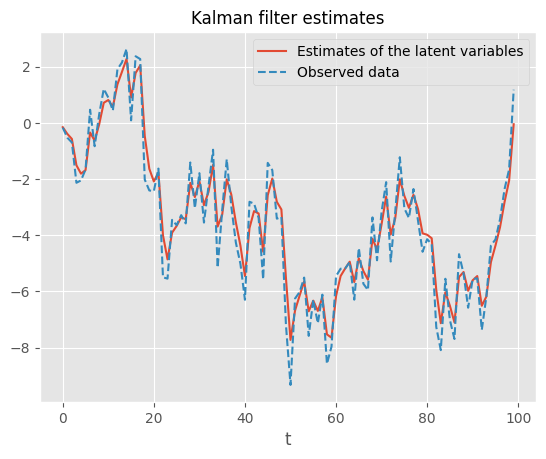

In [6]:
# Plotting the obtained estimates
plt.plot(X_hat, label='Estimates of the latent variables')
plt.plot(Y, ls='--',label='Observed data')
plt.xlabel("t")
plt.title("Kalman filter estimates",size=12)
plt.legend()

#### SMC

In [6]:
y_seq = [torch.tensor(i) for i in Y]

In [7]:
y_seq[0]

tensor(-0.1666)

In [28]:
def run_smc(y_seq, lambda_, N, T, model, proposal_type):
    '''
    >> y_seq: list of torch.tensor
    >> lambda_: proposal parameters
    >> N: number of particles
    >> T: number of time steps
    >> model: dict containing the functions for prior and 
    likelihood, proposal and proposal_logpdf
    >> type_proposal: str specifying the proposal type; can
    be "prior", "opt", "NF" or "VSMC"
    '''
    # Initialize distributions
    if proposal_type == "prior":
        get_log_w = lambda y, x: likelihood(y, x)
    elif proposal_type == "VSMC":
        get_log_w = lambda
    elif proposal_type == "opt":
        print("Not implemented yet")
        return None
    
    # Initialize 
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        log_w[t] = (prior(x_t, x_prev) + likelihood(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, lambda_)).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    # i = b_T
    for t in reversed(range(T)):
        x_est[t] = x_particles[t, b_T]
        if t > 0:
            i = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_est

    
    # return log_w, x_particles


SyntaxError: invalid syntax (3718840160.py, line 16)

In [7]:
def SMC_with_prior(y, N=1000):
    '''
    aaaaaaaaaaaaaaaaaaaaaaaa
    ---
    '''
    T = len(y)
        
    # Storage for particles and weights
    x = [[] for _ in range(N)]       # list of particle trajectories
    w = np.zeros((T, N))             # weights: shape [T x N]
    a = np.zeros((T, N), dtype=int)  # ancestry indices
    
    # Initialization: t = 1
    for i in range(N):
        x_i = Normal(0,1).sample() #proposal(params, None).sample()  # simulate x_1 from r(x_1; λ)
        x[i].append(x_i)
            
        # Compute log weights
        # cur_w = Normal(0,1).log_prob(x_i)                    # prior 
        # cur_w += Normal(x_i,1).log_prob(torch.tensor(y[0]))  # likelihood 
        # cur_w -= proposal(params, None).log_prob(x_i)                # proposal
        w[0, i] = Normal(x_i,1).log_prob(torch.tensor(y[0]))#cur_w #.exp()
    
    # Normalize weights
    # w[0] /= np.sum(w[0])
    prob_choice = np.exp(w[0] - logsumexp(w[0])) #w[0]/np.sum(w[0])
    
    # Sequential steps: t = 2 to T
    for t in range(1, T):
        x_new = [[] for _ in range(N)]
        for i in range(N):
            # Resample ancestor index according to weights
                
            a_t = np.random.choice(N, p = prob_choice)
            a[t, i] = a_t
    
            # Simulate x_t from r(x_t | x_{t-1}; λ)
            x_t = Normal(x[a_t][-1], 1).sample()# proposal(params, x[a_t][-1]).sample()
                
            # Set new trajectory x_{1:t}
            x_new[i] = x[a_t][:] + [x_t]
    
            # Compute weight
            # cur_w = Normal(x_new[i][-1], 1).log_prob(x_t)      # prior 
            # cur_w += Normal(x_t, 1).log_prob(torch.tensor(y[t]))      # likelihood 
            # cur_w -= proposal(params, x[a_t][-1]).log_prob(x_t)  # proposal
            w[t, i] =  Normal(x_t, 1).log_prob(torch.tensor(y[t])) #cur_w.exp()
    
        x = x_new
        prob_choice = np.exp(w[t] - logsumexp(w[t])) #w[t]/np.sum(w[t])
        # w[t] /= np.sum(w[t])  # normalize weights
    
    # Final selection
    b_T = np.random.choice(N, p = prob_choice)
    x_T = x[b_T]
    
    return x_T, w


## Sequential Monte Carlos approaches

All of the approaches considered are versions of Sequential Monte Carlo. As they are being applied to the same model and dataset, the prior and likelihood distributions are the same. The only difference studied in this work is the choice of proposal distribution. Therefore, we define belllow the prior and likelihood distributions to be used.

In [7]:
def likelihood(x_t):
    '''
    Defines g( y_t | x_t ).
    
    Returns:
        The torch.distribution of y_t given x_t. The 
        returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_t: (torch.tensor)
    '''
    return Normal(x_t, 1)
    
def prior(x_prev):
    '''
    Defines f(x_0) and f(x_t | x_{t-1}).

    Returns: 
        The torch.distribution of x_0 or of x_t given x_{t-1}.
        The returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_prev: (torch.tensor or None)
    '''
    if x_prev is None:
        # Initial distribution of process X_t
        return Normal(0,1)
    else:
        # Transition distribution of process X_t
        return Normal(0.95*x_prev, 1)

Also, we can already define some functions useful for evaluating each approach, such as effective sample size, log marginal likelihood estimates, and mean and variance of estimates.

In [8]:
def ESS(log_w): 
    '''
    Calculates the effective sample size.

    Returns:
        A torch.tensor with the effective sample size
        at each time step.
    ---
    >> log_w: the log weights of SMC through time steps (torch.tensor)
    '''
    log_w_norm = log_w - torch.logsumexp(log_w, dim=1, keepdim=True)
    w = torch.exp(log_w_norm)
    ess = 1.0 / torch.sum(w**2, dim=1)
    return ess

# ...

### SMC with prior as proposal

The first approach we will consider for comparison is the classical SMC with the prior distribution as the proposal.

In [9]:
def SMC_prior(y_seq, N, T, latent_dim=1):
    '''
    Apply SMC algorithm using the prior distribution
    as the proposal.

    Returns:
        log_w: obtained log weights (torch.tensor)
        x_particles: all particles generated (torch.tensor)
        ancestors: ancestors sampled through SMC (torch.tensor)
        x_estimates: final estimates for the latent data (torch.tensor)
    ---
    >> y_seq: observed data (list of torch.tensor)
    >> N: number of particles (int)
    >> T: number of time steps (int)
    >> latent_dim: dimension of the observed data (int)
    '''
    # Initialize
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Step 1
    x_t = prior(None).sample((N,latent_dim))
    x_particles[0] = x_t
    log_w[0] = likelihood(x_t).log_prob(y_seq[0]).squeeze()

    # Steps from 2 to T
    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = prior(x_prev).sample()
        x_particles[t] = x_t

        log_w[t] = likelihood(x_t).log_prob(y_seq[t]).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [10]:
N = 1000
T = 100
log_w_prior, x_part_prior, a_prior, x_prior = SMC_prior(y_seq, N, T)

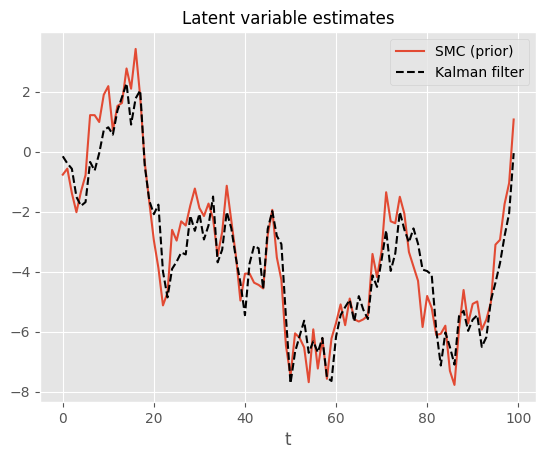

In [11]:
# Plotting estimates
plt.plot(x_prior.numpy(), label='SMC (prior)')
plt.plot(X_hat, label='Kalman filter', c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

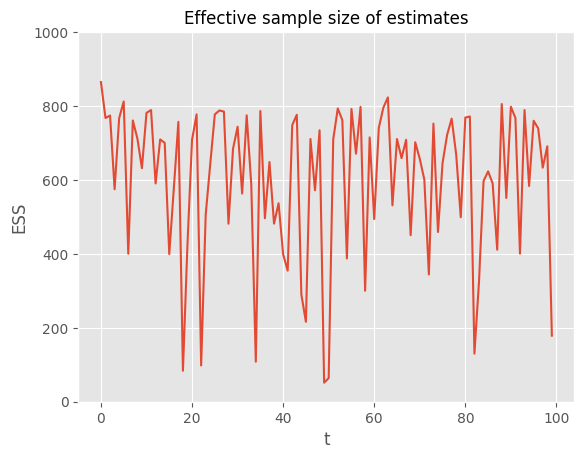

In [12]:
# Plotting ESS
ESS_prior = ESS(log_w_prior)
plt.plot(ESS_prior)
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

## SMC with optimal proposal 

In [13]:
def optimal_proposal(x_prev, y_t, A=.95, C=1, Q=1, R=1):
    if x_prev is None:
        x_prev = 0.0
    var_inv = 1/Q + (C ** 2)/R
    sigma2 = 1/var_inv
    mu = sigma2 * (A * x_prev/Q + C * y_t/R)
    return Normal(mu, math.sqrt(sigma2))


def SMC_opt(y_seq, N, T, latent_dim = 1):
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    x_t = optimal_proposal(None, y_seq[0]).sample((N,))
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) +
        likelihood(x_t).log_prob(y_seq[0]) -
        optimal_proposal(None, y_seq[0]).log_prob(x_t)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = optimal_proposal(x_prev, y_seq[t]).sample()
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) +
            likelihood(x_t).log_prob(y_seq[t]) -
            optimal_proposal(x_prev, y_seq[t]).log_prob(x_t)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [14]:
N = 1000
T = 100
log_w_opt, x_part_opt, a_opt, x_opt = SMC_opt(y_seq, N, T)

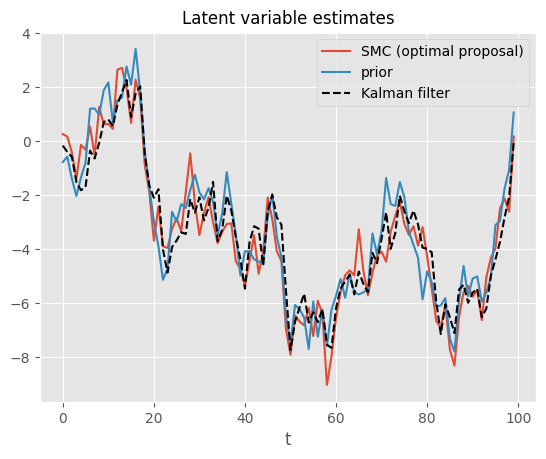

In [15]:
# Plotting estimates
plt.plot(x_opt.numpy(),label='SMC (optimal proposal)')
plt.plot(x_prior.numpy(),label='prior')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

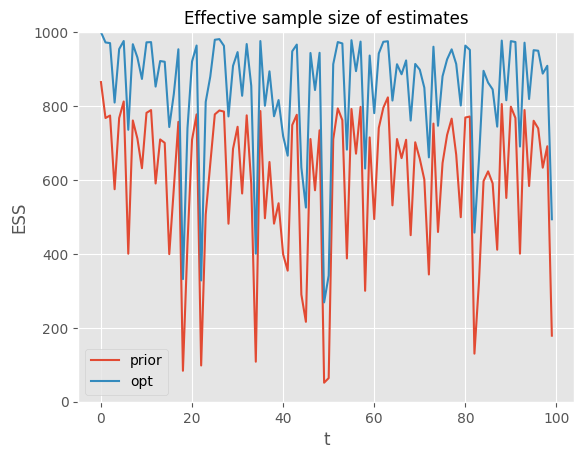

In [16]:
# Plotting ESS
ESS_opt = ESS(log_w_opt)
plt.plot(ESS_prior,label='prior')
plt.plot(ESS_opt, label='opt')
plt.legend()
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

## Variational SMC



In [17]:
class LinearProposal(nn.Module):
    def __init__(self, a, b=torch.tensor([0.0]), c=torch.tensor([0.0]), log_sigma=torch.tensor([1.0])):
        super().__init__()
        self.a = a #nn.Parameter(torch.tensor([0.5]))
        self.b = b #nn.Parameter(torch.tensor([0.5]))
        self.c = c #nn.Parameter(torch.tensor([0.0]))
        self.log_sigma = log_sigma #nn.Parameter(torch.tensor([0.0]))

    def forward(self, x_prev, y_t, eps):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return mu + std * eps

    def log_prob(self, x, x_prev, y_t):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return Normal(mu, std).log_prob(x)



def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()
    

In [18]:
# VSMC
def VSMC(y_seq, N, T, proposal, latent_dim = 1):
    # latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Reparametrization trick
    eps = torch.randn(N, latent_dim)
    x_t = proposal.forward(torch.tensor([0.0]), y_seq[0], eps)#, proposal_id)
    
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) 
        + likelihood(x_t).log_prob(y_seq[0])
        - proposal.log_prob(x_t, torch.tensor([0.0]), y_seq[0])#, proposal_id)
    ).squeeze()

    for t in range(1, T):
        
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal.forward(x_prev, y_seq[t], eps)# lambda_)#, proposal_id)
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) 
            + likelihood(x_t).log_prob(y_seq[t]) 
            - proposal.log_prob(x_t, x_prev, y_seq[t])#, proposal_id)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    i = b_T
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, i]
        if t > 0:
            i = ancestors[t, i]

    return log_w, x_particles, ancestors, x_estimates


In [33]:
def train_vsmc(y_seq, T, N, n_steps=100, lr=1e-3):

    a = nn.Parameter(torch.randn((1,)))
    b = nn.Parameter(torch.tensor([0.0]))
    c = nn.Parameter(torch.tensor([0.0]))
    log_sigma = nn.Parameter(torch.tensor([0.0]))
    
    # b = torch.tensor([0.0])
    # c = torch.tensor([0.0])
    # log_sigma = torch.tensor([1.0])
    
    proposal = LinearProposal(a, b, c, log_sigma)
    
    optimizer = torch.optim.Adam(proposal.parameters(), lr=lr)
    history = []
    
    # Training loop
    for step in range(n_steps):
        optimizer.zero_grad()
        log_w,_,_,_ = VSMC(y_seq, N, T, proposal)#, proposal_id)
        elbo = surrogate_elbo(log_w)
        loss = -elbo
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            with torch.no_grad():
                print(f"Step {step:03d} | ELBO: {elbo.item():.2f}")# | grad: {proposal.paramaters().grad.item():.4f}")
                # print(proposal.a, proposal.b, proposal.log_sigma)
            # print(lambda_,'\n')
        history.append(loss.item())
    print(f"Training finished!\nFinal loss: {loss.item()}")
    return history, proposal

In [345]:
small_y = y_seq[:5]

In [36]:
n_steps = 150
T = 100
N = 1000
history, proposal = train_vsmc(y_seq, T, N, n_steps,lr=0.1)

Step 000 | ELBO: -577.13
Step 010 | ELBO: -189.13
Step 020 | ELBO: -194.11
Step 030 | ELBO: -189.33
Step 040 | ELBO: -202.96
Step 050 | ELBO: -193.40
Step 060 | ELBO: -198.14
Step 070 | ELBO: -191.89
Step 080 | ELBO: -200.02
Step 090 | ELBO: -188.02
Step 100 | ELBO: -200.82
Step 110 | ELBO: -193.46
Step 120 | ELBO: -189.50
Step 130 | ELBO: -188.89
Step 140 | ELBO: -194.20
Training finished!
Final loss: 195.07272338867188


Text(0.5, 1.0, 'Loss history')

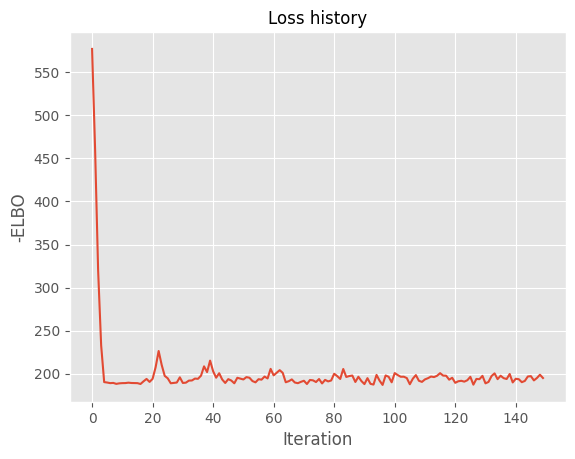

In [38]:
plt.plot(history)
plt.ylabel("-ELBO")
plt.xlabel("Iteration")
plt.title("Loss history",size=12)

In [51]:
N = 1000
T = 100
log_w_vsmc_lin, x_part_vsmc_lin, a_vsmc_lin, x_vsmc_lin = VSMC(y_seq, N, T, proposal)

In [48]:
small_y = y_seq[:]

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.30it/s]


Text(0.5, 1.0, 'ELBO landscape')

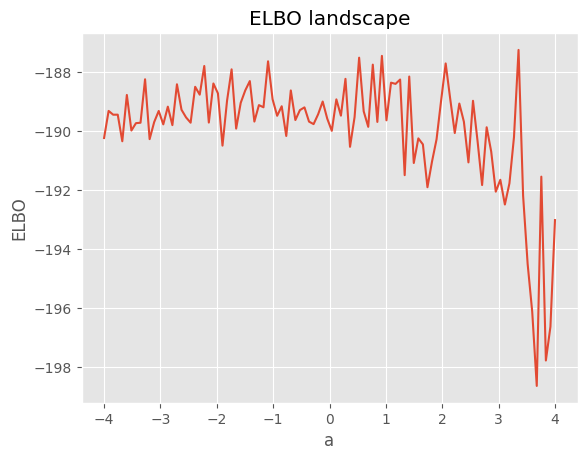

In [50]:
lambdas = torch.linspace(-4, 4, 100)
elbos = []

for val in tqdm(lambdas):
    lambda_test = torch.tensor([val])
    proposal_test = LinearProposal(
        a=torch.tensor([0.5]),
        c=lambda_test
    )
    log_w, _, _, _ = VSMC(small_y, 1000, 100, proposal_test)
    elbos.append(surrogate_elbo(log_w).item())

plt.plot(lambdas.numpy(), elbos)
plt.xlabel("a")
plt.ylabel("ELBO")
plt.title("ELBO landscape")

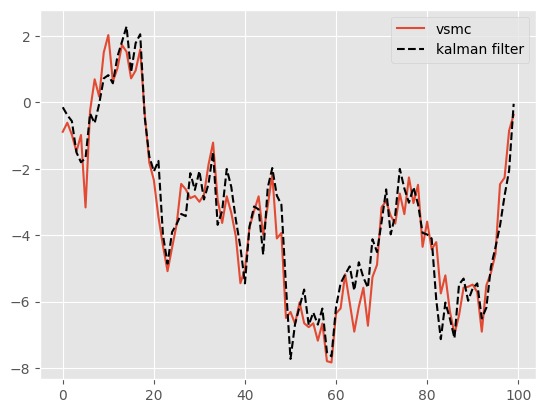

In [52]:
plt.plot(x_vsmc_lin.detach().numpy(),label='vsmc')
plt.plot(X_hat,label='kalman filter',c='black',ls='--')
# plt.plot(x_prior.numpy(), label="SMC with prior")
# plt.plot(x_opt.numpy(), label="SMC optimal")
plt.legend()

In [57]:
ESS(log_w_vsmc_lin)

tensor([ 9.7774,  5.7251,  5.3300,  6.2696,  7.6664,  7.2326,  7.2706,  2.8260,
         5.9709,  5.9247,  4.7260,  8.6482, 12.0691, 14.1296,  8.2046,  7.1501,
         7.1469, 12.2116,  6.1553,  5.6791,  6.4824,  9.3516,  2.8566, 14.9070,
        10.5895,  4.4866,  4.7436,  7.4094,  7.7664,  6.0324,  8.4783,  3.7119,
         9.8439,  5.0633,  2.8257,  5.0657,  7.3567,  9.5962, 13.7139, 10.1489,
         3.9939, 15.7878, 12.4455,  5.9537,  8.2980, 15.5980, 10.0434,  7.7844,
        17.7809,  8.8074,  1.6212,  9.5553,  8.7167,  6.6855,  7.7779,  9.8742,
        14.8226, 13.4475,  4.9636, 11.7799,  9.3691,  9.6467,  8.9150, 13.9931,
         7.0937,  5.4382, 11.2618,  3.7947, 13.8896,  7.4114,  7.7804, 11.3282,
         6.1402,  6.9901,  7.4305,  5.7784,  5.3437,  9.7038,  3.8052,  3.0784,
         4.4200, 13.4628,  4.0288,  2.7079,  6.8248,  8.5875, 15.7114,  7.4457,
         5.6403,  6.7679, 17.5378, 19.1205,  5.9019, 11.6683, 14.1467,  8.4274,
         6.2776, 10.7813,  6.2370,  6.89

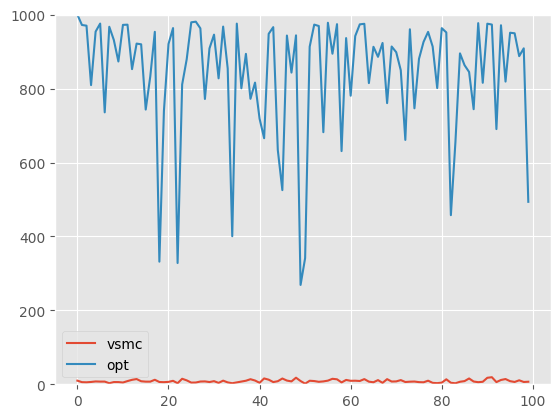

In [56]:
plt.plot(ESS(log_w_vsmc_lin).detach().numpy(),label='vsmc')
# plt.plot(ESS(log_w_prior),label='prior')
plt.plot(ESS(log_w_opt),label='opt')
plt.ylim((0,N))
plt.legend()

In [246]:
n_steps = 150
T = 100
N = 1000
history, lambda_2 = train_vsmc(y_seq, T, N, 1, n_steps,lr=0.01)

Parameter containing:
tensor([0.9500], requires_grad=True) 

Step 000 | ELBO: -189.26 | grad: -427.6988
Parameter containing:
tensor([0.9500], requires_grad=True) 

Step 010 | ELBO: -190.05 | grad: 1176.6512
Parameter containing:
tensor([1.0511], requires_grad=True) 

Step 020 | ELBO: -188.51 | grad: -832.2629
Parameter containing:
tensor([1.0332], requires_grad=True) 

Step 030 | ELBO: -189.48 | grad: 725.5983
Parameter containing:
tensor([1.0525], requires_grad=True) 

Step 040 | ELBO: -188.80 | grad: -60.6811
Parameter containing:
tensor([1.0453], requires_grad=True) 

Step 050 | ELBO: -189.25 | grad: -356.6816
Parameter containing:
tensor([1.0449], requires_grad=True) 

Step 060 | ELBO: -189.06 | grad: 341.4381
Parameter containing:
tensor([1.0429], requires_grad=True) 

Step 070 | ELBO: -189.65 | grad: 340.7644
Parameter containing:
tensor([1.0471], requires_grad=True) 

Step 080 | ELBO: -189.05 | grad: 887.3358
Parameter containing:
tensor([1.0473], requires_grad=True) 

Step 090

Text(0.5, 1.0, 'Loss history')

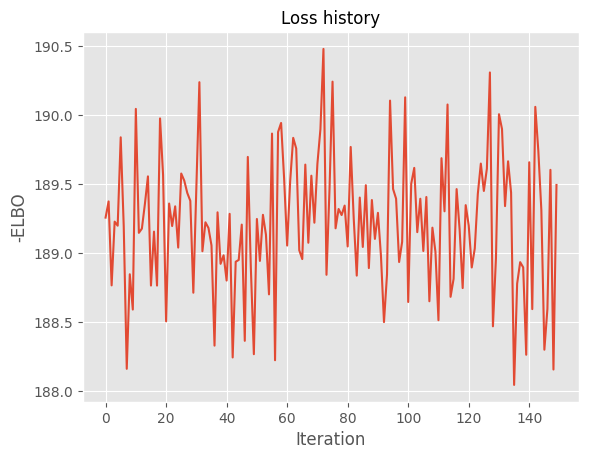

In [247]:
plt.plot([i.detach() for i in history])
plt.ylabel("-ELBO")
plt.xlabel("Iteration")
plt.title("Loss history",size=12)

In [234]:
log_w_vsmc_2, x_part_vsmc_2, a_vsmc_2, x_vsmc_2 = VSMC(y_seq, lambda_2, N, T, proposal_id=1)

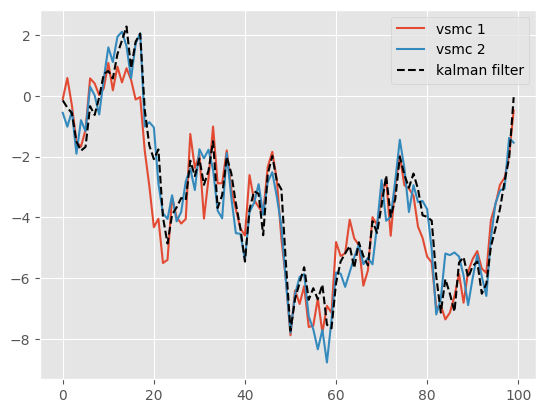

In [235]:
plt.plot(x_vsmc_1.detach().numpy(),label='vsmc 1')
plt.plot(x_vsmc_2.detach().numpy(),label='vsmc 2')
plt.plot(X_hat,label='kalman filter',c='black',ls='--')
# plt.plot(x_prior.numpy(), label="SMC with prior")
# plt.plot(x_opt.numpy(), label="SMC optimal")
plt.legend()

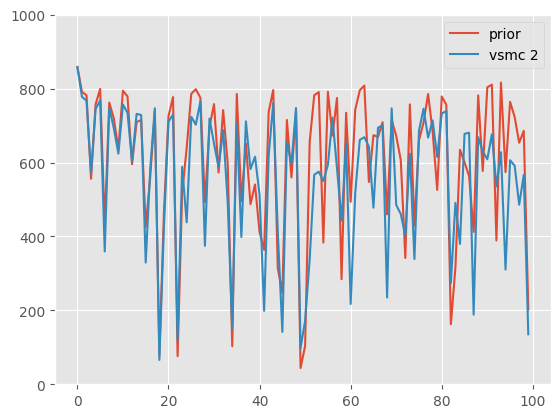

In [240]:
plt.plot(ESS(log_w_prior).numpy(),label='prior')
# plt.plot(ESS(log_w_vsmc_1).detach().numpy(),label='vsmc 1')
plt.plot(ESS(log_w_vsmc_2).detach().numpy(),label='vsmc 2')
# plt.plot(ESS(log_w_prior),label='prior')
# plt.plot(ESS(log_w_opt),label='opt')
plt.ylim((0,N))
plt.legend()

# Code that didn't work

In [285]:
# Distributions
def prior(x, x_prev):
    if x_prev == None:
        return Normal(0,1).log_prob(x)
    else:
        return Normal(0.95*x_prev, 1).log_prob(x)


def likelihood(y_t, x_t):
    return Normal(x_t, 1).log_prob(y_t)


def proposal_logpdf(x, x_prev, lambda_):
    if x_prev is None:
        return Normal(lambda_, 1).log_prob(x)
    else:
        return Normal(lambda_ + 0.5*x_prev,1).log_prob(x)


def proposal(x_prev, eps, lambda_):
    if x_prev is None:
        mu = lambda_
    else:
        mu = lambda_ + 0.5 * x_prev
    return eps + mu


# VSMC
def run_vsmc(y_seq, lambda_, N, T):
    '''
    y_seq: list of torch.tensor's 
    '''
    latent_dim = 1 #y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)).squeeze()
    
    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        cur_log_w = (
            prior(x_t, x_prev)
            + likelihood(y_seq[t], x_t)
            - proposal_logpdf(x_t, x_prev, lambda_)
        )
        log_w[t] = cur_log_w.reshape((N,))

    return log_w, x_particles, ancestors


In [286]:
num_epochs = 100
T = 100
N = 1000
lambda_ = nn.Parameter(torch.randn(N,), requires_grad=True)

y_seq = [torch.tensor([i]) for i in Y]
optimizer = torch.optim.Adam([lambda_], lr=1e-4)

history = []

for epoch in tqdm(range(num_epochs)):
    log_w, _, _ = run_vsmc(y_seq, lambda_, N, T)
    elbo = surrogate_elbo(log_w)
    loss = -elbo  # Maximize ELBO
    loss = torch.autograd.Variable(loss, requires_grad = True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(lambda_.grad)

    history.append(loss)

  0%|                                                   | 0/100 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (1) must match the existing size (1000) at non-singleton dimension 1.  Target sizes: [1000, 1].  Tensor sizes: [1000, 1000]

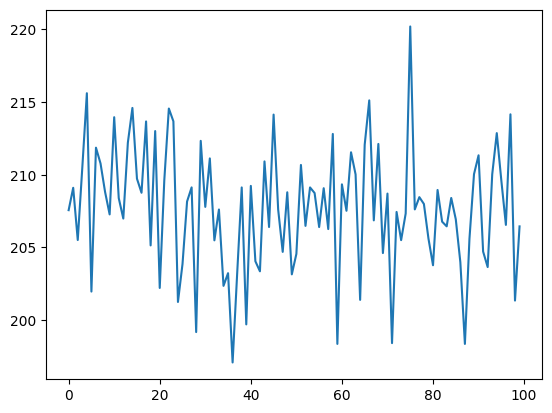

In [247]:
plt.plot([i.detach() for i in history])

# Normalizing Flow

---

# References

\[1\] T. Lacey, "Tutorial: The Kalman Filter". Accessed: Jul. 09, 2025. \[Online\]. Available: https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf.

\[2\] C. A. Naesseth, S. W. Linderman, R. Ranganath, and D. M. Blei, "Variational Sequential Monte
Carlo." \[Online\]. Available: https://arxiv.org/abs/1705.11140.